<a href="https://colab.research.google.com/github/JulibethTinoco/covid-19/blob/master/forecasting_covid19_colombia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### COVID-19





Fuente de datos:
https://www.ins.gov.co/Noticias/Paginas/Coronavirus.aspx

Objetivo: identificar el mejor modelo entre SARIMAX,TBATS,LSTM Networks y NNETAR para predecir el numero de casos de coronavirus en Colombia al día siguiente y/o semana siguiente con la finalidad de que el sistema de salud estime la demanda que abrá.

In [0]:
#Importing Libraries

import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt
import os


from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
#from pandas.tools.plotting import autocorrelation_plot

#from pyramid.arima import auto_arima
#from pmdarima.arima import auto_arima
#import pyflux as pf
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [7]:
#loading data
path="/casos_covid19_colombia.csv"
df=pd.read_csv(path) 
df.head()

,ID de caso,Fecha de diagnóstico,Ciudad de ubicación,Departamento,Atención,Edad,Sexo,Tipo,País de procedencia,Estado,Fecha de Estado,Caso Nuevo
0,1,6/3/2020,Bogotá,Bogotá,casa,10 a 19,F,Importado,Italia,Recuperado,NaN,NaN
1,2,9/3/2020,Buga,Valle,hospital,30 a 39,M,Importado,España,Recuperado,NaN,NaN
2,3,9/3/2020,Medellín,Antioquia,casa,50 a 59,F,Importado,España,Recuperado,NaN,NaN
3,4,11/3/2020,Medellín,Antioquia,casa,50 a 59,M,Relacionado,Colombia,Activo,NaN,NaN
4,5,11/3/2020,Medellín,Antioquia,casa,20 a 29,M,Relacionado,Colombia,Activo,NaN,NaN


In [8]:
#dim
len(df)

491

In [9]:
df.columns

Index(['ID de caso', 'Fecha de diagnóstico', 'Ciudad de ubicación',
       'Departamento', 'Atención', 'Edad', 'Sexo', 'Tipo',
       'País de procedencia', 'Estado', 'Fecha de Estado', 'Caso Nuevo'],
      dtype='object')

In [10]:
df.columns = ['id_caso','fecha', 'ciudad_ubicacion', 'dpto','atencion', 'edad', 'sexo', 'tipo','pais_procedencia','estado','fecha_estado','caso_nuevo']
df.head(3)

,id_caso,fecha,ciudad_ubicacion,dpto,atencion,edad,sexo,tipo,pais_procedencia,estado,fecha_estado,caso_nuevo
0,1,6/3/2020,Bogotá,Bogotá,casa,10 a 19,F,Importado,Italia,Recuperado,NaN,NaN
1,2,9/3/2020,Buga,Valle,hospital,30 a 39,M,Importado,España,Recuperado,NaN,NaN
2,3,9/3/2020,Medellín,Antioquia,casa,50 a 59,F,Importado,España,Recuperado,NaN,NaN


In [11]:
df.fecha=pd.to_datetime(df.fecha, format='%d/%m/%Y')
df.set_index('fecha', inplace=True)
df.head(3)

,id_caso,ciudad_ubicacion,dpto,atencion,edad,sexo,tipo,pais_procedencia,estado,fecha_estado,caso_nuevo
fecha,,,,,,,,,,,
2020-03-06,1,Bogotá,Bogotá,casa,10 a 19,F,Importado,Italia,Recuperado,NaN,NaN
2020-03-09,2,Buga,Valle,hospital,30 a 39,M,Importado,España,Recuperado,NaN,NaN
2020-03-09,3,Medellín,Antioquia,casa,50 a 59,F,Importado,España,Recuperado,NaN,NaN


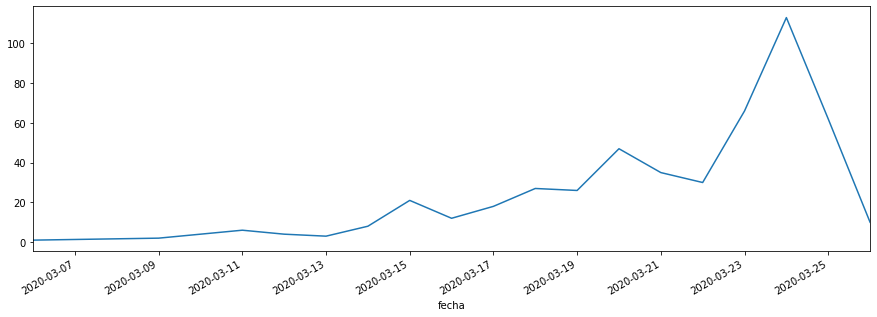

In [12]:
ts = df.groupby("fecha")["id_caso"].count()
ts.plot(figsize=(15,5))
data = pd.DataFrame(df.groupby("fecha")["id_caso"].count())

In [31]:
data.head(5)

,id_caso
fecha,
2020-03-06,1
2020-03-09,2
2020-03-11,6
2020-03-12,4
2020-03-13,3


In [27]:
data.describe()

,id_caso
count,18.000000
mean,27.277778
std,29.158402
min,1.000000
25%,6.500000
50%,19.500000
75%,33.750000
max,113.000000


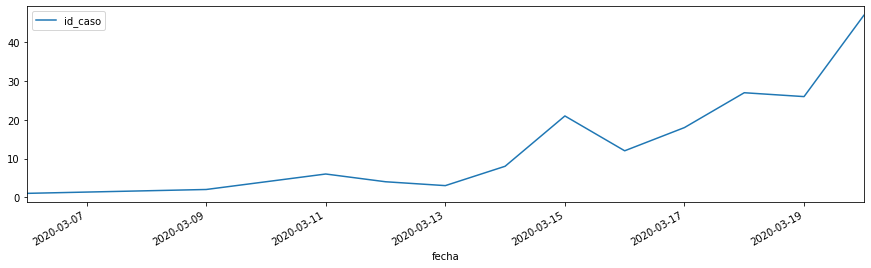

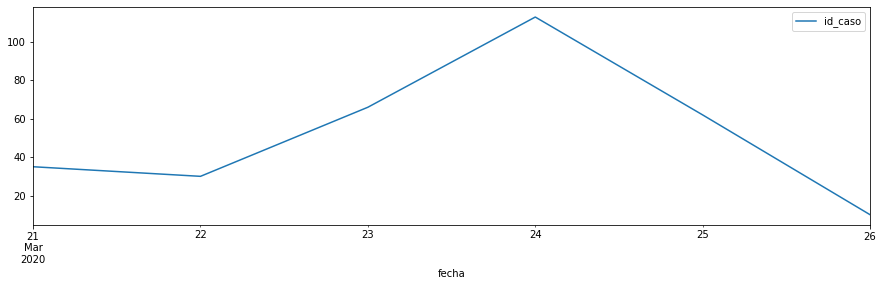

In [14]:
test_period = int(data.shape[0]*0.8)
train = data.iloc[:12,].dropna()
test = data.iloc[12:,].dropna()
train.plot(figsize=(15,4))
test.plot(figsize=(15,4))

**Dickey Fuller's Test**

In [15]:
t = sm.tsa.adfuller(train.id_caso, autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                 1.497833
p-value                        0.997516
#Lags Used                     4.000000
Number of Observations Used    7.000000
dtype: float64

In [0]:
# function for differencing
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset.iloc[i] - dataset.iloc[i - interval]
        diff.append(value)
    return diff

In [17]:
t  = sm.tsa.adfuller(difference(train.id_caso,1), autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                 -3.600478
p-value                         0.005752
#Lags Used                      0.000000
Number of Observations Used    10.000000
dtype: float64

Por lo tanto, la serie no es estacionaria.

**Seasonal Decomposition**



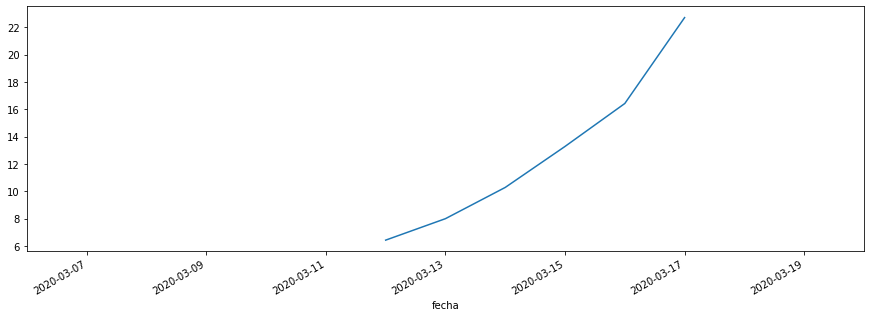

In [18]:
s = sm.tsa.seasonal_decompose(train.id_caso,freq=7)
s.trend.plot(figsize=(15,5))

**SARIMAX**


In [19]:
model = sm.tsa.statespace.SARIMAX(train['id_caso'], order=(0,1,2),trend='c')
model_fit = model.fit()
model_fit.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                id_caso   No. Observations:                   12
Model:               SARIMAX(0, 1, 2)   Log Likelihood                 -36.933
Date:                Fri, 27 Mar 2020   AIC                             81.865
Time:                        16:41:58   BIC                             83.457
Sample:                             0   HQIC                            80.862
                                 - 12                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4541      1.962      1.761      0.078      -0.391       7.299
ma.L1         -0.9197    962.398     -0.001      0.999   -1887.186    1885.346
ma.L2         -0.0800     77.409     -0.001      0.999    -151.800     151.640
sigma2        39.0078   3.75e+04      0.001      0.999   -7.35e+04    7.36e+04
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 3.78
Prob(Q):                               nan   Prob(JB):                         0.15
Heteroskedasticity (H):               2.61   Skew:                             1.31
Prob(H) (two-sided):                  0.38   Kurtosis:                         4.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

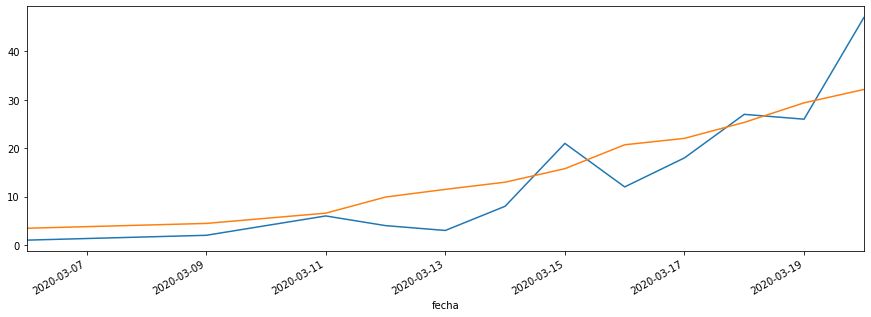

In [20]:
#model fit
train['id_caso'].plot(figsize=(15,5))
model_fit.fittedvalues.plot()
plt.show()

In [21]:
#prediction
predict = model_fit.predict(start = len(train),end = len(train)+len(test)-1)
test['predicted'] = predict.values
test.tail(5)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


,id_caso,predicted
fecha,,
2020-03-22,30,40.613693
2020-03-23,66,44.067750
2020-03-24,113,47.521807
2020-03-25,62,50.975864
2020-03-26,10,54.429920


In [22]:
#score
test['residual'] = abs(test['id_caso']-test['predicted'])
MAE = test['residual'].sum()/len(test)
MAPE = (abs(test['residual'])/test['id_caso']).sum()*100/len(test)
print("MAE:", MAE)
print("MAPE:", MAPE)

MAE: 26.121611141150897
MAPE: 99.65415928357994


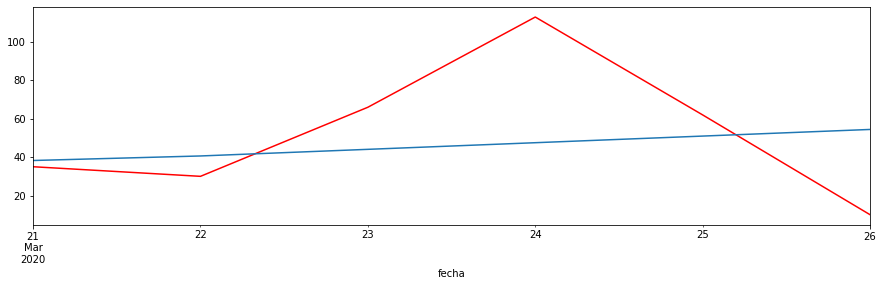

In [23]:
test['id_caso'].plot(figsize=(15,4),color = 'red')
test['predicted'].plot()
plt.show()

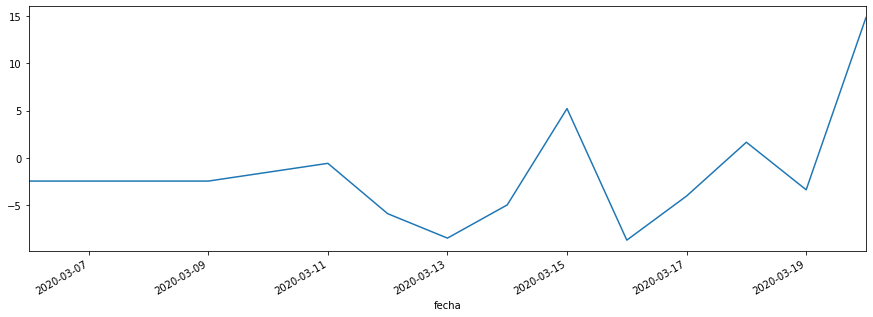

In [24]:
model_fit.resid.plot(figsize= (15,5))

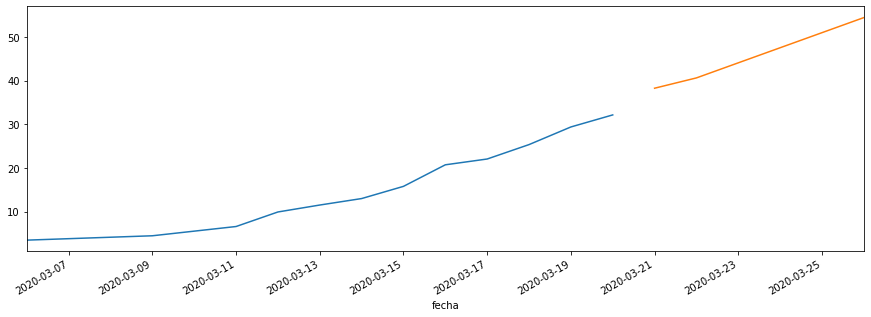

In [25]:
model_fit.fittedvalues.plot(figsize = (15,5))
test.predicted.plot()

**LSTM**

*How to Convert a Time Series to a Supervised Learning Problem in Python?* -> https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [0]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    dat = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dat.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dat.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [33]:
data_sup = series_to_supervised(data, 3,1)
data_sup.head(5)

,var1(t-3),var1(t-2),var1(t-1),var1(t)
fecha,,,,
2020-03-12,1.0,2.0,6.0,4
2020-03-13,2.0,6.0,4.0,3
2020-03-14,6.0,4.0,3.0,8
2020-03-15,4.0,3.0,8.0,21
2020-03-16,3.0,8.0,21.0,12


In [0]:
#Normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_sup = scaler.fit_transform(data_sup)